In [1]:
using DIVAnd
using PyPlot
using Proj4
using DelimitedFiles
using PyCall
using Dates
using NCDatasets
include("../scripts/BenthosInterp.jl")
doplot = true

true

## Files and directories

In [2]:
figdir = "../product/figures/"
outputdir = "../product/"
datadir = "../data/"
datafile = joinpath(datadir, "specs4Diva.csv")
isdir(figdir) ? "Figure directory already exists" : mkpath(figdir)
isdir(outputdir) ? "Output directory already exists" : mkpath(outputdir)
# change the file URL
#isfile(datafile) ? @info("File already downloaded") : download("https://dox.ulg.ac.be/index.php/s/VgLglubaTLetHzc/download", datafile)

"Output directory already exists"

In [ ]:
domain = [-16., 9., 45., 66.]

## Prepare mask
### Interpolation grid

In [3]:
longrid = -16.:0.1:9.
latgrid = 45.:0.1:66.

45.0:0.1:66.0

### Download file

In [4]:
bathname = joinpath(datadir, "gebco_30sec_4.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download", bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[4]:5


### Read bathymetry

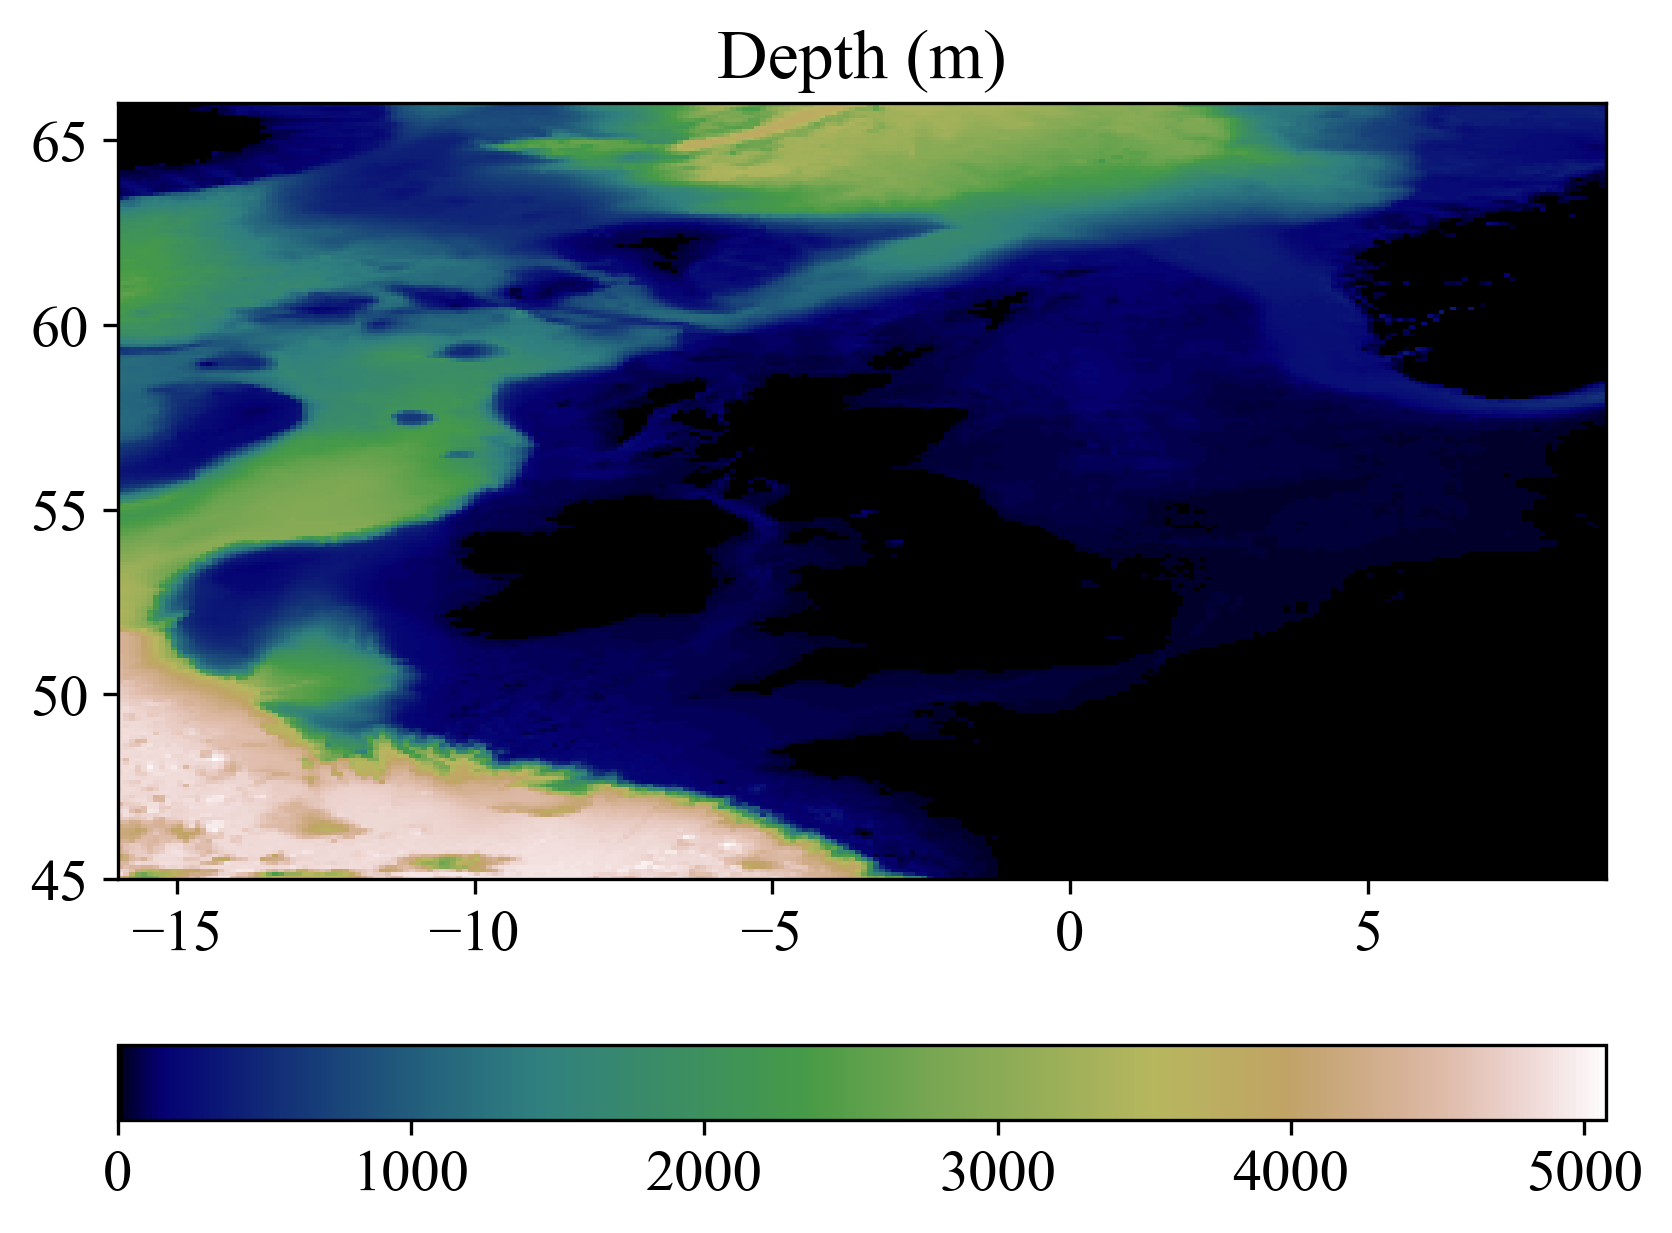

size(b) = (251, 211)


In [5]:
bx, by, b = load_bath(bathname, true, longrid, latgrid)
@show size(b)

if doplot
    fig = PyPlot.figure()
    ax = PyPlot.subplot(111)
    pcolor(bx,by,b', vmin=0., cmap=PyPlot.cm.gist_earth); 
    colorbar(orientation="horizontal")
    title("Depth (m)")
    show()
end

### Metrics

In [6]:
mask, (pm, pn),(xi, yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);
xi, yi, mask = DIVAnd.load_mask(bathname, true, longrid, latgrid, 0.0);
xx, yy = ndgrid(xi, yi);

## Interpolation
### Data reading
Generate a list of species

In [7]:
specnames = get_species_list(datafile);

Loop on all the species: 
* read the data
* compute the heatmaps and 
* derive the probability field as:
```
d = npre * dens2 / (npre * dens2 + nabs * dens3)
```
The reason for this equation is that the heatmap are computed so that their integral over the domain is 1, whatever the number of observations. 

In [30]:
speciesnamelist = get_species_list(datafile)
L = 0.2

species = speciesnamelist[1]
    
speciesslug = get_species_slug(String(species))
@info(speciesslug)
@info("Working on species $(species)");
lon_pre, lat_pre, lon_abs, lat_abs = read_coords_species(datafile, species);
npre = length(lon_pre)
nabs = length(lon_abs)

@info("Number of presence: $(npre), number of absence: $(nabs)")

@info("Computing heatmaps")

@time dens2, LHM2, LCV2, LSCV2 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_pre, lat_pre), ones(npre), L);
@time dens3, LHM3, LCV3, LSCV3 = DIVAnd_heatmap(mask, (pm,pn), (xx, yy), 
    (lon_abs, lat_abs), ones(nabs), L);


d = npre .* dens2 ./ (npre .* dens2 .+ nabs .* dens3);

@info("Computing error field with CPME")
lon = [lon_pre ; lon_abs]
lat = [lat_pre ; lat_abs]

cpme = DIVAnd_cpme(mask, (pm, pn), (xx, yy), (lon, lat), 
    ones(length(lon)), 0.5, 5.);

if doplot
plot_heatmap2(longrid, latgrid, d, lon_pre, lat_pre, lon_abs, lat_abs,
    "$(species): probability", joinpath(figdir, "$(speciesslug)_density.png"))
end

if doplot
    plot_error2(longrid, latgrid, cpme, "$(species)", 
        joinpath(figdir, "$(speciesslug)_error.png"))
end   

create_nc_results(joinpath(outputdir, "$(speciesslug)_density.nc"), 
    longrid, latgrid, d, String(species));

# Add the error field
write_nc_error(joinpath(outputdir, "$(speciesslug)_density.nc"), cpme);

┌ Info: Abra_alba
└ @ Main In[30]:7
┌ Info: Working on species Abra_alba
└ @ Main In[30]:8
┌ Info: Column index for Abra_alba: 5
└ @ Main /home/ctroupin/Projects/EMODnet/EMODnet-Biology-Benthos-Interpolated-Maps/scripts/BenthosInterp.jl:19
┌ Info: Number of presence: 14068, number of absence: 65977
└ @ Main In[30]:13
┌ Info: Computing heatmaps
└ @ Main In[30]:15
┌ Warning: Data array size (14068,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 17.534830 seconds (501.72 k allocations: 6.264 GiB, 3.25% gc time)


┌ Warning: Data array size (65977,) is larger then maximum 10000. Superobservations will be created. To avoid, increase nmax to the desired number of superobs
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_heatmap.jl:48


 33.711213 seconds (2.14 M allocations: 12.477 GiB, 0.90% gc time)


┌ Info: Computing error field with CPME
└ @ Main In[30]:25


LoadError: UndefVarError: plot_heatmap2 not defined

Create a new field that takes into account the error field:
* if error is zero, we take the gridded field as it is;
* if error is close to 1, it means we don't have observations so the new field is zero (assuming that we don't have observations means there is nothing to observe);
* if error is between 0 and 1, we calculate the field as 

In [42]:
function plot_heatmap(longrid::StepRangeLen, latgrid::StepRangeLen,
    dens::Array, lonobs::Vector, latobs::Vector, occurs::Vector,
    titletext::String, figname::String="", vmin=0., vmax=1.)

    data_presence = occurs .== 1;
    data_absence = occurs .== 0;

    llon, llat = ndgrid(longrid, latgrid)
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111)
    ax.plot(lonobs[data_presence], latobs[data_presence], "wo", markersize=1., zorder=3)
    ax.plot(lonobs[data_absence], latobs[data_absence], "ko", markersize=1., zorder=3)
    pcm = ax.pcolor(llon, llat, dens, cmap=PyPlot.cm.hot_r, zorder=2, vmin=vmin, vmax=vmax)
    colorbar(pcm, orientation="horizontal"  )
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_heatmap (generic function with 8 methods)

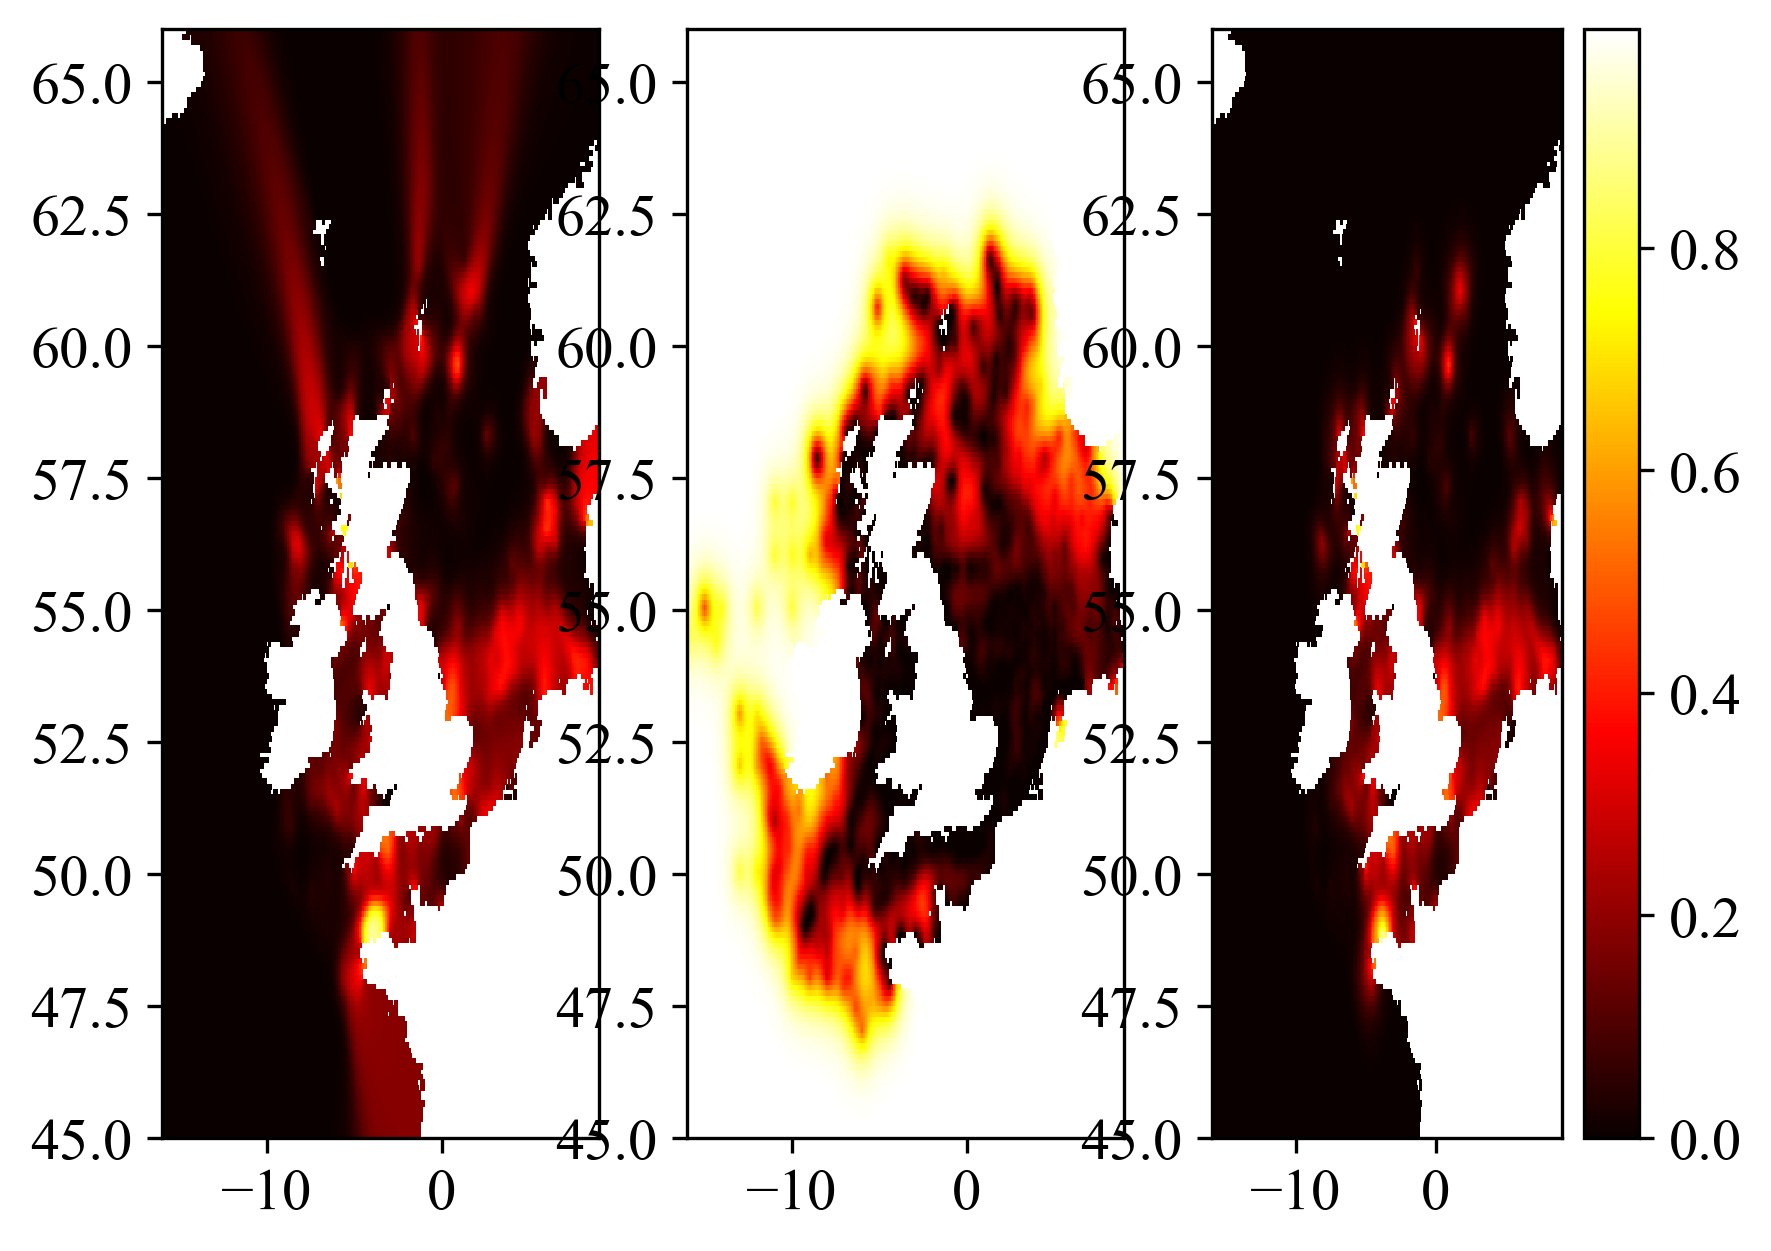

PyObject <matplotlib.colorbar.Colorbar object at 0x7effc9371610>

In [41]:
plot_heatmap(longrid, latgrid, d, lon_pre, lat_pre:Vector, occurs::Vector,
    titletext::String, "", vmin=0., vmax=1.)


In [39]:
newfield = (1. .- cpme) .* d;

In [40]:
size(newfield)

(251, 211)

In [43]:
ccrs = pyimport("cartopy.crs")
gridliner = pyimport("cartopy.mpl.gridliner")
cfeature = pyimport("cartopy.feature")
mticker = pyimport("matplotlib.ticker")
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="full");
mpl = pyimport("matplotlib");
cartopyticker = pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()

PyObject <cartopy.mpl.ticker.LatitudeFormatter object at 0x7effe1bb2c50>

In [44]:
function decorate_map(ax, plotcoast=true;
         domain=[-16., 9., 45., 66.], dlon::Float64=2., dlat::Float64=2.)
    PyPlot.grid(linewidth=0.2)
    if plotcoast
        ax.add_feature(coast, color=".6",
            edgecolor="k", zorder=5)
    end
    ax.set_xlim(domain[1], domain[2])
    ax.set_ylim(domain[3], domain[4])
    ax.set_xticks(domain[1]:dlon:domain[2])
    ax.set_yticks(domain[3]:dlat:domain[4])
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
end

decorate_map (generic function with 2 methods)

In [45]:
function plot_heatmap(longrid::StepRangeLen, latgrid::StepRangeLen,
    dens::Array, lon_pre::Array, lat_pre::Array, lon_abs::Array, lat_abs::Array, 
    titletext::String, figname::String="", vmin=0., vmax=maximum(dens);
    domain=[-16., 9., 45., 66.], dlon=2., dlat=2.)

    data_presence = occurs .== 1;
    data_absence = occurs .== 0;

    llon, llat = ndgrid(longrid, latgrid)
    myproj = ccrs.PlateCarree()
    fig = PyPlot.figure(figsize=(12,8))
    ax = PyPlot.subplot(111, projection=myproj)
    decorate_map(ax, true; domain=domain, dlon=dlon, dlat=dlat)
    ax.plot(lonobs[data_presence], latobs[data_presence], "go", markersize=1, zorder=4,
            label="Presence")
    ax.plot(lonobs[data_absence], latobs[data_absence], "ko", markersize=2.5, zorder=3,
            label="Absence")
    pcm = ax.pcolor(llon, llat, dens, cmap=PyPlot.cm.RdYlBu_r, zorder=2, vmin=vmin, vmax=vmax)
    PyPlot.legend(loc=2)
    colorbar(pcm, orientation="vertical")
    title(titletext)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
        PyPlot.close()
    else
        PyPlot.show()
    end
end

plot_heatmap (generic function with 8 methods)